# Pytorch CNN - Brain Tumor Detection
# https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from glob import glob

import sklearn
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Use Cuda")
else:
    device = torch.device('cpu')
    print("Use CPU")

Use Cuda


# Upload data zip file

* local folder에서 colab으로 파일 불러오기

In [3]:
from google.colab import files
# archive.zip 을 선택하면 됩니다.
files_upload = files.upload()

Saving archive.zip to archive.zip


In [ ]:
!unzip archive.zip

In [5]:
file_dir = 'archive/brain_tumor_dataset/'

# 1. Load data and preprocessing

* 이미지 파일 형식 및 차원 확인

In [6]:
path = glob(file_dir+'/yes/*')
for image in path[:5]:
  img = Image.open(image).convert("RGB")
  print(img, np.asarray(img).shape)

<PIL.Image.Image image mode=RGB size=254x312 at 0x7FEE9D790A10> (312, 254, 3)
<PIL.Image.Image image mode=RGB size=630x630 at 0x7FEE9B286850> (630, 630, 3)
<PIL.Image.Image image mode=RGB size=911x938 at 0x7FEE9D790490> (938, 911, 3)
<PIL.Image.Image image mode=RGB size=226x223 at 0x7FEE9B286AD0> (223, 226, 3)
<PIL.Image.Image image mode=RGB size=526x555 at 0x7FEE9B286850> (555, 526, 3)


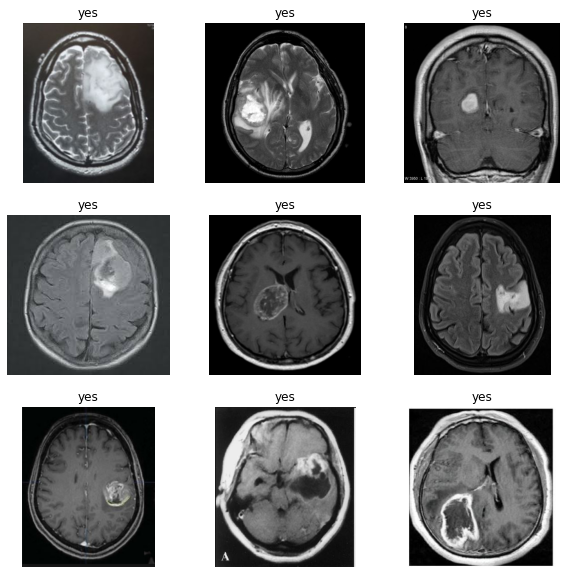

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
  img = path[i]
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img))
  plt.title(os.path.split(os.path.split(img)[0])[-1])
  plt.axis("off")

* 데이터 로드 클래스 (변경하지 마세요!)

In [8]:
# Do not change this class !!
class BrainMRIDataset(Dataset):

    def __init__(self, file_dir, transform):
      self.dataDirectory = file_dir
      self.transform = transform

      self.no_class = glob(file_dir+'/no/*')
      self.yes_class = glob(file_dir+'/yes/*')
      self.file_list = self.no_class + self.yes_class
      self.label_list = [0]*len(self.no_class) + [1]*len(self.yes_class)
      self.dataframe = pd.DataFrame({'image': self.file_list,
                                     'label': self.label_list})  
      self.dataframe = shuffle(self.dataframe)
      self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
      return len(self.no_class)+len(self.yes_class)

    def __getitem__(self, index):
      img_path = self.dataframe['image'][index]
      labels = self.dataframe['label'][index]
      labels = labels.tolist()
      
      if type(img_path) == str:
        img_path = [img_path]

      img_array = []
      for image in img_path:
        img = Image.open(image).convert("RGB")
        img_transformed = self.transform(img)
        array = np.asarray(img_transformed)
        img_array.append(array)
            
      return [torch.tensor(img_array, device=device),torch.tensor(labels, device=device)]
    
    def __repr__(self):
      print("Data loading succeed!!")
      print("-"*100)
      plt.figure(figsize=(10, 10))
      for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(self.file_list[i]))
        plt.title(os.path.split(os.path.split(self.file_list[i])[0])[-1])
        plt.axis("off")

      rep = pd.DataFrame({'File Path' : self.file_list})
      return str(rep.head(9))

# customize your transformation

In [9]:
# you can add other 'torcivision.transforms.'
data_transform = transforms.Compose([
                                     # add transforms
                                     transforms.Resize((128,128)), # do not change resize!!
                                     transforms.ToTensor(),        # do not change totensor!!
                                     ])

In [10]:
# data_transform 을 정의하고, 밑의 코드의 결과값이 모두 (3,128,128)이 나오는지 확인하세요.
path = glob(file_dir+'/yes/*')
for image in path[:5]:
  img = Image.open(image).convert("RGB")
  print(np.asarray(data_transform(img)).shape)

(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)


Data loading succeed!!
----------------------------------------------------------------------------------------------------


                                   File Path
0  archive/brain_tumor_dataset//no/28 no.jpg
1     archive/brain_tumor_dataset//no/N2.JPG
2  archive/brain_tumor_dataset//no/22 no.jpg
3  archive/brain_tumor_dataset//no/20 no.jpg
4   archive/brain_tumor_dataset//no/4 no.jpg
5  archive/brain_tumor_dataset//no/50 no.jpg
6  archive/brain_tumor_dataset//no/21 no.jpg
7   archive/brain_tumor_dataset//no/no 2.jpg
8  archive/brain_tumor_dataset//no/27 no.jpg

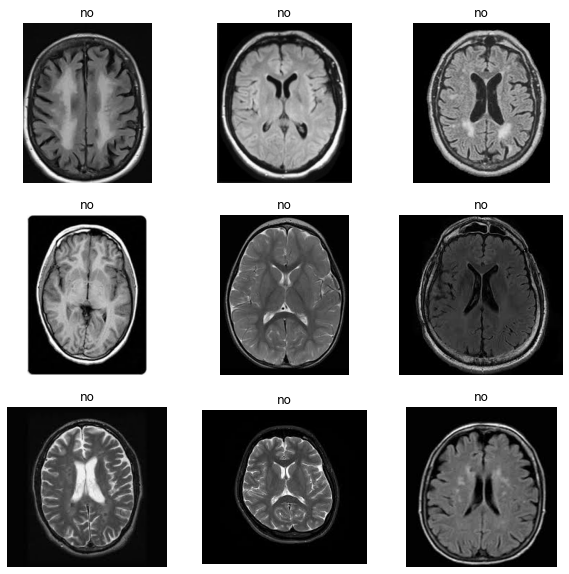

In [11]:
# load the data
dataset = BrainMRIDataset(file_dir, transform = data_transform)
dataset

# 2. Modeing

In [12]:
# can change, but remind the dimension
# First input must be : [1, 3, 128, 128]
# Last output must be : [1, 2]

class BrainTumorModel(nn.Module):
    
    def __init__(self):
        super().__init__()
            # input : [1, 3, 128, 128]
        self.layer1 = nn.Sequential(
          nn.Conv2d(3,64,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(64,64,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2))              # output : [1, 64, 64, 64]
        
        self.layer2 = nn.Sequential(
          nn.Conv2d(64,128,kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(128,128,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2))              # output : [1, 128, 32, 32]

        self.layer3 = nn.Sequential(
          nn.Conv2d(128,256,kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(256,256,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2))              # output : [1, 256, 16, 16]

        self.layer4 = nn.Sequential(
          nn.Conv2d(256,512,kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2))              # output : [1, 512, 8, 8]

        self.flat = nn.Flatten(1)                 # output : [1, 512*8*8]
        self.linear1 = nn.Linear(512*8*8,512*8)   # output : [1, 512*8]
        self.linear2 = nn.Linear(512*8,512*8)     # output : [1, 512*8]
        self.linearout = nn.Linear(512*8,2)       # output : [512*8, 2]

    def forward(self,x):
        # input : [1, 3, 128, 128]
        x = self.layer1(x)              # output : [1, 64, 64, 64]
        x = self.layer2(x)              # output : [1, 128, 32, 32]
        x = self.layer3(x)              # output : [1, 256, 16, 16]
        x = self.layer4(x)              # output : [1, 512, 8, 8]

        x = F.relu(self.flat(x))        # output : [1, 512*8*8]
        x = F.relu(self.linear1(x))     # output : [1, 512*8]
        x = F.relu(self.linear2(x))     # output : [1, 512*8]
        x = self.linearout(x)           # output : [1, 2]

        return x

In [13]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

# 3. Training

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [15]:
# divide dataset to train and test.
train, test = random_split(dataset, [200, 53],generator=torch.Generator().manual_seed(42))
print("Total number of dataset:",len(dataset))
print("Train dataset:",len(train))
print("Test dataset:",len(test)) 

Total number of dataset: 253
Train dataset: 200
Test dataset: 53


In [19]:
epochs = 100
batch_size = 8
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(train)//batch_size):
    
        data, target = train[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target.long())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch % 5 == 0:
      print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 0.689780592918396
Epochs: 5 Loss: 0.6575459241867065
Epochs: 10 Loss: 0.5836431980133057
Epochs: 15 Loss: 0.5445659756660461
Epochs: 20 Loss: 0.41031450033187866
Epochs: 25 Loss: 0.3865671753883362
Epochs: 30 Loss: 0.22452151775360107
Epochs: 35 Loss: 0.10374279320240021
Epochs: 40 Loss: 0.1267986297607422
Epochs: 45 Loss: 0.02241744101047516
Epochs: 50 Loss: 0.008008627220988274
Epochs: 55 Loss: 0.00045850075548514724
Epochs: 60 Loss: 5.748825060436502e-05
Epochs: 65 Loss: 2.452847911627032e-05
Epochs: 70 Loss: 1.4183990970195737e-05
Epochs: 75 Loss: 9.412393410457298e-06
Epochs: 80 Loss: 6.754455171176232e-06
Epochs: 85 Loss: 5.101978786115069e-06
Epochs: 90 Loss: 3.989522156189196e-06
Epochs: 95 Loss: 3.19612854582374e-06


# 4. Visualize the result

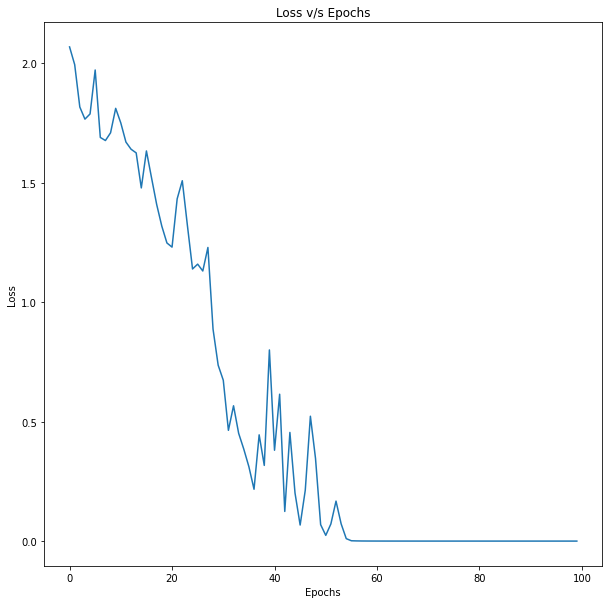

In [20]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 5. Testing

In [21]:
correct = 0
total = 0

with torch.no_grad():
  for data in test:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images.float())
        
    _, predicted = torch.max(outputs.data, 1)
        
    total += 1
        
    correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (
    100 * correct / total))

Accuracy of test images: 73 %
